In [25]:
!which python

/Users/ahmadabdullahtariq/Documents/Projects/Thesis/.venv/bin/python


# SVR
- https://stats.stackexchange.com/questions/82044/how-does-support-vector-regression-work-intuitively
- https://stats.stackexchange.com/questions/13194/support-vector-machines-and-regression

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

from sklearn.svm import SVR,LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error


import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (30, 8)
mpl.rcParams['axes.grid'] = True
from evaluation import forecast_accuracy

In [2]:
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')

print(df.isna().sum())
print(df.dtypes)

DOA         0
DBA         0
LAR      5040
ADR      4950
Rooms       0
ROH         0
dtype: int64
DOA       object
DBA      float64
LAR      float64
ADR      float64
Rooms    float64
ROH      float64
dtype: object


## Preprocessing

In [3]:
def preprocess(dx):
    # drop Null entries
    dx = dx[~dx['LAR'].isna()]
    dx['DOA'] = pd.to_datetime(dx['DOA'])

    # Normalize Rooms 
    dx.loc[dx['Rooms']==0,'Rooms'] = dx['Rooms'].max()
    # Normalize ROH 
    dx.loc[dx['ROH']==0,'ROH'] = dx['ROH'].median()
    # convert to OCC
    dx['ROH'] = dx['ROH']/dx['Rooms']
    dx = dx.drop(columns=['Rooms'])
    # dx = dx.drop(columns=['Rooms','LAR','ADR'])


    dx['DOW'] = dx['DOA'].dt.dayofweek
    dx['Mon'] = dx['DOA'].dt.month
    dx['Day'] = dx['DOA'].dt.day

    # just to make DOA unique
    dx['DOA'] = dx['DOA']+dx['DBA'].apply(lambda x: timedelta(minutes=(1440-((x+1)*16)))) 
    dx = dx.set_index('DOA')
    dx.loc[dx['ROH']>1,'ROH']=1.0
    # scaling 
    scaler = StandardScaler()
    cols = [col for col in dx.columns if col != 'ROH']
    dx[cols] = scaler.fit_transform(dx[cols])
    return dx

def train_test_split(dx):
    index = int(len(dx)*0.8)
    train = dx[:index]
    test  = dx[index:]
    return train,test

In [4]:
df = preprocess(df)

<ipython-input-3-e2567ce49fb9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dx['DOA'] = pd.to_datetime(dx['DOA'])
/home/ahmad/Desktop/thesis/.venv/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/home/ahmad/Desktop/thesis/.venv/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [5]:
df.head(10)

,DBA,LAR,ADR,ROH,DOW,Mon,Day
DOA,,,,,,,
2018-01-01 00:00:00,1.712912,-0.828820,-0.830304,0.860465,-1.4852,-1.566804,-1.683037
2018-01-01 00:16:00,1.674419,-0.828820,-0.830304,0.813953,-1.4852,-1.566804,-1.683037
2018-01-01 00:32:00,1.635927,-0.828820,-0.806895,0.790698,-1.4852,-1.566804,-1.683037
2018-01-01 00:48:00,1.597434,-0.828820,-0.806895,0.767442,-1.4852,-1.566804,-1.683037
2018-01-01 01:04:00,1.558942,-0.594387,-0.596217,0.767442,-1.4852,-1.566804,-1.683037
2018-01-01 01:20:00,1.520450,-0.594387,-0.537696,0.744186,-1.4852,-1.566804,-1.683037
2018-01-01 01:36:00,1.481957,-0.477171,-0.479174,0.744186,-1.4852,-1.566804,-1.683037
2018-01-01 01:52:00,1.443465,-0.477171,-0.479174,0.744186,-1.4852,-1.566804,-1.683037
2018-01-01 02:08:00,1.404972,-0.477171,-0.401145,0.744186,-1.4852,-1.566804,-1.683037


## Test/Train Split 

In [6]:
train, test = train_test_split(df)

## Visualization

In [7]:
def plot_train_test(train, test):
    train = train[train['DBA']== train['DBA'].max()]
    test = test[test['DBA']== train['DBA'].max()]
    plt.plot(train.index, train['ROH'], label='Train')
    plt.plot(test.index, test['ROH'], label='Test')
    plt.xlabel('DOA')
    plt.ylabel('ROH')
    plt.legend(loc='best')
    plt.show()

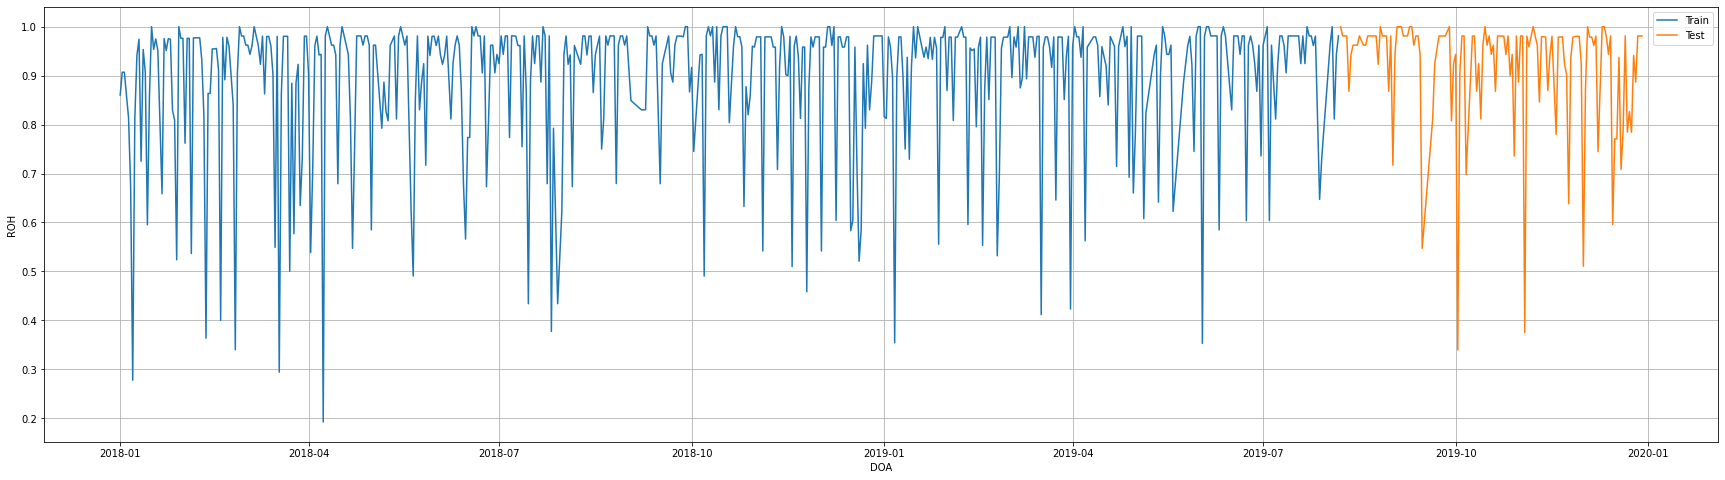

In [8]:
plot_train_test(train,test)

In [9]:
y = train.pop('ROH')
X = train

In [11]:
# from sklearn.model_selection import GridSearchCV
# param = {'kernel' :['rbf'],'C' : [1], 'epsilon':[0.01],'gamma' : ('auto','scale')},

# modelsvr = SVR()
# grids = GridSearchCV(estimator=modelsvr,param_grid=param,cv=5,scoring='neg_mean_squared_error')
# grids.fit(X,y)
# grids.best_params_
# grids.best_estimator_

In [ ]:
# {'C': 10, 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
svr_rbf = SVR(kernel='rbf', C=1, gamma='scale', epsilon=0.01)
model_rbf = svr_rbf.fit(X,y)
test['svm_rbf'] = model_rbf.predict(test[['DBA','LAR','ADR','ROH','DOW','Mon']]) 
# test['svm_rbf'] = model_rbf.predict(test[['DBA','ROH','DOW','Mon']]) 

In [ ]:
dx = test[test['DBA']==test['DBA'].max()]

plt.plot(dx.index, dx['ROH'], label='test')
# plt.plot(dx.index, dx['svm_reg'], label='svm_reg')
plt.plot(dx.index, dx['svm_rbf'], label='svm_rbf')
plt.xlabel('DOA')
plt.ylabel('ROH')
plt.legend(loc='best')
plt.show()

In [ ]:
# rmse = mean_squared_error(test['ROH'], test['svm_rbf'], squared=False)
# mape = np.mean(np.abs((test['svm_rbf']-test['ROH'])/test['ROH'])) # mape

# print(round(rmse,4),"\t&",round(mape,4))
forecast_accuracy(test['svm_rbf'],test['ROH'])

## Combined Results

In [17]:
clean_hotels = [  48,   80,   86,  148,  151,  199,  269,  284,  317,  322,  577,1041, 1100, 1479, 1968, 4290]
result = []
for hotelId in clean_hotels:
    df = pd.read_pickle('../dataset/preprocessed/'+str(hotelId)+'_imputed.pkl')
    df = preprocess(df)
    train, test = train_test_split(df)
    cols = df.columns 
    
    model = create_model(train)
    pred = model.forecast(len(test))
    eval = forecast_accuracy(pred,test.ROH)

SVM Reg MSE: 0.572 MAE: 0.642 R2: 0.479245


In [22]:
from sklearn.model_selection import cross_validate

scoring = {'r2':'r2', 'MSE':'neg_mean_squared_error'}
for degree in range(2,7):
    res = cross_validate(polynomialRegression(degree), X, y, cv=270,scoring=scoring, return_train_score=True)
    
    print("Poly degree:",degree)
    print("R2  Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(res['test_r2'].mean(),res['test_r2'].std()* 2,res['train_r2'].mean(),res['train_r2'].std()* 2))
    print("MSE Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(res['test_MSE'].mean(),res['test_MSE'].std()* 2,res['train_MSE'].mean(),res['train_MSE'].std()* 2))
    print("RMSE Test Score: %0.2f (+/- %0.2f)) | Train Score: %0.2f (+/- %0.2f))"%(np.sqrt(-res['test_MSE']).mean(),np.sqrt(-res['test_MSE']).std()* 2,np.sqrt(-res['train_MSE']).mean(),np.sqrt(-res['test_MSE']).std()* 2))

NameError: name 'polynomialRegression' is not defined

# With ROH

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR,LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [27]:
df = pd.read_pickle('../dataset/preprocessed/48_imputed.pkl')

In [28]:
df['DOA'] = pd.to_datetime(df['DOA'])

df['ROH'] = df['ROH']/df['Rooms']
df = df.drop(columns=['LAR','ADR','Rooms'])

## consider DBA
cols = [89,79,69,59,49,39,29,19,9,0]
df   = df[df['DBA'].isin(cols)]

In [29]:
df.head()

,DOA,DBA,ROH
0,2018-01-01,89.0,0.860465
10,2018-01-01,79.0,0.744186
20,2018-01-01,69.0,0.590909
30,2018-01-01,59.0,0.440000
40,2018-01-01,49.0,0.400000


In [30]:
df = df.pivot(index='DOA',columns='DBA',values='ROH')
df = df.bfill(axis=1).ffill(axis=1)

In [31]:
df.head()

DBA,0.0,9.0,19.0,29.0,39.0,49.0,59.0,69.0,79.0,89.0
DOA,,,,,,,,,,
2018-01-01,0.019608,0.039216,0.156863,0.160000,0.280000,0.400000,0.440000,0.590909,0.744186,0.860465
2018-01-02,0.217391,0.217391,0.304348,0.340909,0.340909,0.363636,0.386364,0.522727,0.697674,0.906977
2018-01-03,0.260870,0.260870,0.304348,0.340909,0.363636,0.386364,0.386364,0.545455,0.697674,0.906977
2018-01-04,0.152174,0.152174,0.195652,0.227273,0.227273,0.272727,0.272727,0.431818,0.395349,0.860465
2018-01-05,0.108696,0.130435,0.173913,0.181818,0.181818,0.204545,0.272727,0.318182,0.325581,0.813953


In [32]:
# scaler = StandardScaler()
# df[['DOW','Price','ROH']] = scaler.fit_transform(df[['DOW','Price','ROH']])
# df = df.pivot(index='DOA',columns='LeadTime',values='ROH')
# df = df.bfill(axis=1).ffill(axis=1)

In [33]:
# # df = df.drop(columns=[1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,19,21])
# cols = df.columns[df.columns.isin([89,79,69,59,49,39,29,19,9,0])]
# df = df[cols]

In [35]:
df['DOW'] = df.index.dayofweek
df['Mon'] = df.index.month


In [37]:
index = int(len(df)*0.8)
train = df[:index]
test  = df[index:]

In [38]:
y = train.pop(0)
X = train

In [40]:
X

DBA,9.0,19.0,29.0,39.0,49.0,59.0,69.0,79.0,89.0,DOW,Mon
DOA,,,,,,,,,,,
2018-01-01,0.039216,0.156863,0.160000,0.280000,0.400000,0.440000,0.590909,0.744186,0.860465,0,1
2018-01-02,0.217391,0.304348,0.340909,0.340909,0.363636,0.386364,0.522727,0.697674,0.906977,1,1
2018-01-03,0.260870,0.304348,0.340909,0.363636,0.386364,0.386364,0.545455,0.697674,0.906977,2,1
2018-01-04,0.152174,0.195652,0.227273,0.227273,0.272727,0.272727,0.431818,0.395349,0.860465,3,1
2018-01-05,0.130435,0.173913,0.181818,0.181818,0.204545,0.272727,0.318182,0.325581,0.813953,4,1
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-03,0.981132,0.981132,0.981132,0.981132,0.981132,0.981132,0.981132,0.981132,1.000000,5,8
2019-08-04,0.094340,0.094340,0.132075,0.150943,0.169811,0.264151,0.471698,0.716981,0.811321,6,8
2019-08-05,0.056604,0.056604,0.094340,0.113208,0.169811,0.301887,0.396226,0.622642,0.943396,0,8


In [41]:
from sklearn.model_selection import GridSearchCV
param = {'kernel' : ('linear', 'rbf'),'C' : [1,5,10],'degree' : [3,8],'coef0' : [0.01,10,0.5],'gamma' : ('auto','scale')},

modelsvr = SVR()

grids = GridSearchCV(estimator=modelsvr,param_grid=param,cv=5,scoring='neg_mean_absolute_error')

grids.fit(X,y)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=({'C': [1, 5, 10], 'coef0': [0.01, 10, 0.5],
                          'degree': [3, 8], 'gamma': ('auto', 'scale'),
                          'kernel': ('linear', 'rbf')},),
             scoring='neg_mean_absolute_error')

In [43]:
grids.best_params_

{'C': 10, 'coef0': 0.01, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}

In [47]:
test.loc[:, test.columns != 0]

DBA,9.0,19.0,29.0,39.0,49.0,59.0,69.0,79.0,89.0,DOW,Mon
DOA,,,,,,,,,,,
2019-08-08,0.886792,0.886792,0.886792,0.830189,0.830189,0.830189,0.830189,0.962264,0.981132,3,8
2019-08-09,0.452830,0.471698,0.471698,0.471698,0.471698,0.415094,0.547170,0.698113,0.981132,4,8
2019-08-10,0.433962,0.452830,0.490566,0.490566,0.660377,0.622642,0.716981,0.622642,0.981132,5,8
2019-08-11,0.735849,0.735849,0.754717,0.754717,0.924528,0.471698,0.509434,0.433962,0.867925,6,8
2019-08-12,0.207547,0.226415,0.226415,0.226415,0.415094,0.452830,0.547170,0.679245,0.943396,0,8
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-27,0.415094,0.471698,0.528302,0.735849,0.886792,0.867925,0.811321,0.867925,0.981132,4,12
2019-12-28,0.207547,0.301887,0.415094,0.547170,0.754717,0.735849,0.792453,0.905660,0.981132,5,12
2019-12-29,0.056604,0.169811,0.283019,0.377358,0.660377,0.622642,0.660377,0.754717,0.981132,6,12


In [49]:
ypred = grids.best_estimator_.predict(test.loc[:, test.columns != 0])

In [51]:
test.index

DatetimeIndex(['2019-08-08', '2019-08-09', '2019-08-10', '2019-08-11',
               '2019-08-12', '2019-08-13', '2019-08-14', '2019-08-15',
               '2019-08-16', '2019-08-17',
               ...
               '2019-12-22', '2019-12-23', '2019-12-24', '2019-12-25',
               '2019-12-26', '2019-12-27', '2019-12-28', '2019-12-29',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', name='DOA', length=146, freq=None)

In [55]:
forecast_accuracy(ypred,test[0])

{'mape': inf, 'mae': 0.057, 'mpe': nan, 'rmse': 0.076}

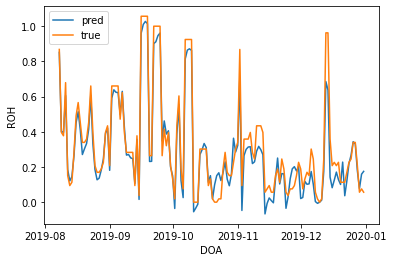

In [52]:
plt.plot(test.index, ypred, label='pred')
plt.plot(test.index, test[0], label='true')
plt.xlabel('DOA')
plt.ylabel('ROH')
plt.legend(loc='best')
plt.show()

In [18]:
from sklearn.model_selection import KFold

df_train    = df.loc[:'2019-10']
df_test     = df.loc['2019-10':]

y = df_train.pop(0)
X = df_train

result = {'train':[],'test':[]}
kf = KFold(random_state=None, shuffle=False, n_splits=16)

for train_index, test_index in kf.split(X):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
    model_rbf = svr_rbf.fit(X_train, y_train)

    # svm_reg = LinearSVR(epsilon=0.5)
    # model_rbf = svm_reg.fit(X_train, y_train) # temp name change
    
    train_svm_rbf = model_rbf.predict(X_train)     
    test_svm_rbf = model_rbf.predict(X_test) 

    train_rmse = np.mean((y_train - train_svm_rbf)**2)**.5  # RMSE
    test_rmse = np.mean((y_test - test_svm_rbf)**2)**.5  # RMSE
    result['train'].append(train_rmse)
    result['test'].append(test_rmse)
    print("Train RMSE ::",round(train_rmse,3),"\tTest RMSE ::",round(test_rmse,3))

print("Mean Train RMSE ::",round(np.mean(result['train']),3),"\tMean Test RMSE ::",round(np.mean(result['test']),3))


Train RMSE :: 0.234 	Test RMSE :: 0.4
Train RMSE :: 0.24 	Test RMSE :: 0.203
Train RMSE :: 0.241 	Test RMSE :: 0.197
Train RMSE :: 0.233 	Test RMSE :: 0.326
Train RMSE :: 0.237 	Test RMSE :: 0.237
Train RMSE :: 0.229 	Test RMSE :: 0.369
Train RMSE :: 0.235 	Test RMSE :: 0.308
Train RMSE :: 0.243 	Test RMSE :: 0.111
Train RMSE :: 0.18 	Test RMSE :: 0.679
Train RMSE :: 0.244 	Test RMSE :: 0.129
Train RMSE :: 0.243 	Test RMSE :: 0.097
Train RMSE :: 0.242 	Test RMSE :: 0.136
Train RMSE :: 0.241 	Test RMSE :: 0.126
Train RMSE :: 0.24 	Test RMSE :: 0.188
Train RMSE :: 0.243 	Test RMSE :: 0.112
Train RMSE :: 0.243 	Test RMSE :: 0.144
Mean Train RMSE :: 0.236 	Mean Test RMSE :: 0.235


In [10]:
# from sklearn.model_selection import TimeSeriesSplit

# df_train    = df.loc[:'2019-10']
# df_test     = df.loc['2019-10':]

# y = df_train.pop(0)
# X = df_train

# tscv = TimeSeriesSplit(max_train_size=None, n_splits=10)

# for train_index, test_index in tscv.split(X):
#     # print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_test = X.iloc[train_index], X.iloc[test_index]
#     y_train, y_test = y.iloc[train_index], y.iloc[test_index]

#     svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
#     model_rbf = svr_rbf.fit(X_train, y_train)

#     # svm_reg = LinearSVR(epsilon=0.5)
#     # model_rbf = svm_reg.fit(X_train, y_train) # temp name change
    
#     train_svm_rbf = model_rbf.predict(X_train)     
#     test_svm_rbf = model_rbf.predict(X_test) 

#     train_rmse = np.mean((y_train - train_svm_rbf)**2)**.5  # RMSE
#     test_rmse = np.mean((y_test - test_svm_rbf)**2)**.5  # RMSE

#     print("Train RMSE ::",round(train_rmse,3),"\tTest RMSE ::",round(test_rmse,3))


In [19]:
pred = model_rbf.predict(df_test.loc[:, df_test.columns != 0]) 

In [20]:
df_test['svm_rbf'] = pred

In [21]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_test.index, y=df_test[0],mode='markers+lines',name='True'))
# fig.add_trace(go.Scatter(x=df_test.index, y=df_test['svm_reg'],mode='markers+lines',name='svm_reg'))
fig.add_trace(go.Scatter(x=df_test.index, y=df_test['svm_rbf'],mode='markers+lines',name='svm_rbf'))

fig.update_layout(autosize=False,width=1000,height=400,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
fig.show()   

In [53]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae  = np.mean(np.abs(forecast - actual))    # MAE
    mpe  = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':round(mape,3), 'mae':round(mae,3) , 'mpe':round(mpe,3) , 'rmse':round(rmse,3)})

In [23]:
# print("SVM Regression ",forecast_accuracy(df_test['svm_reg'],df_test[0]))
print("SVM Radial     ",forecast_accuracy(df_test['svm_rbf'],df_test[0]))

SVM Radial      {'mape': 0.289, 'mae': 0.212, 'mpe': 0.254, 'rmse': 0.333}


# Compile

In [6]:
from sklearn.model_selection import KFold

In [7]:
clean_hotels = [1041, 269, 4290, 48, 317, 151, 322, 1968, 1100, 284, 86, 199, 80, 577, 148, 1479] 
_result = {hotelId:{'mae':None,'rmse':None} for hotelId in clean_hotels}

In [13]:
for hotelId in clean_hotels:
    df = pd.read_pickle('../dataset/preprocessed/'+str(hotelId)+'_imputed.pkl')
    #preprocessing 
    df = df.rename(columns={'Reservations':'ROH'})
    scaler = StandardScaler()
    df[['LAR','ROH']] = scaler.fit_transform(df[['LAR','ROH']])
    df = df.pivot(index='DOA',columns='DBA',values='ROH')
    df = df.bfill(axis=1).ffill(axis=1)
    # df = df.drop(columns=[1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,19,21])
    cols = df.columns[df.columns.isin([89,79,69,59,49,39,29,19,9,0])]
    df = df[cols]
    # df['DOW'] = df.index.dayofweek
    #kfold validation 

    df_train    = df.loc[:'2019-10']
    df_test     = df.loc['2019-10':]

    y = df_train.pop(0)
    X = df_train

    result = {'train':[],'test':[]}
    kf = KFold(random_state=None, shuffle=False, n_splits=16)

    for train_index, test_index in kf.split(X):
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
        model_rbf = svr_rbf.fit(X_train, y_train)

        # svm_reg = LinearSVR(epsilon=0.5)
        # model_rbf = svm_reg.fit(X_train, y_train) # temp name change
        
        train_svm_rbf = model_rbf.predict(X_train)     
        test_svm_rbf = model_rbf.predict(X_test) 

        train_rmse = np.mean((y_train - train_svm_rbf)**2)**.5  # RMSE
        test_rmse = np.mean((y_test - test_svm_rbf)**2)**.5  # RMSE
        result['train'].append(train_rmse)
        result['test'].append(test_rmse)
        # print("Train RMSE ::",round(train_rmse,3),"\tTest RMSE ::",round(test_rmse,3))

    print("Mean Train RMSE ::",round(np.mean(result['train']),3),"\tMean Test RMSE ::",round(np.mean(result['test']),3))
    #predict 
    pred = model_rbf.predict(df_test.loc[:, df_test.columns != 0]) 
    df_test['svm_rbf'] = pred
    # result 
    # fig = go.Figure()
    # fig.add_trace(go.Scatter(x=df_test.index, y=df_test[0],mode='markers+lines',name='True'))
    # # fig.add_trace(go.Scatter(x=df_test.index, y=df_test['svm_reg'],mode='markers+lines',name='svm_reg'))
    # fig.add_trace(go.Scatter(x=df_test.index, y=df_test['svm_rbf'],mode='markers+lines',name='svm_rbf'))

    # fig.update_layout(autosize=False,width=1000,height=400,xaxis_title="Reservations on Hand (ROH)",yaxis_title="Day of Arrival (DOA)")
    # fig.show()   
    # performance
    perfor = forecast_accuracy(df_test['svm_rbf'],df_test[0])
    print("SVM Radial     ",perfor)
    _result[hotelId]['mae'] = perfor['mae']
    _result[hotelId]['rmse'] = perfor['rmse']


Mean Train RMSE :: 0.202 	Mean Test RMSE :: 0.218
SVM Radial      {'mape': 0.299, 'mae': 0.14, 'mpe': 0.071, 'rmse': 0.198}
Mean Train RMSE :: 0.224 	Mean Test RMSE :: 0.227
SVM Radial      {'mape': 0.215, 'mae': 0.098, 'mpe': 0.141, 'rmse': 0.143}
Mean Train RMSE :: 0.444 	Mean Test RMSE :: 0.479
SVM Radial      {'mape': 0.109, 'mae': 0.069, 'mpe': 0.04, 'rmse': 0.089}
Mean Train RMSE :: 0.224 	Mean Test RMSE :: 0.227
SVM Radial      {'mape': 0.215, 'mae': 0.098, 'mpe': 0.141, 'rmse': 0.143}
Mean Train RMSE :: 0.094 	Mean Test RMSE :: 0.113
SVM Radial      {'mape': 0.08, 'mae': 0.075, 'mpe': 0.005, 'rmse': 0.094}
Mean Train RMSE :: 0.103 	Mean Test RMSE :: 0.134
SVM Radial      {'mape': 0.094, 'mae': 0.085, 'mpe': 0.022, 'rmse': 0.109}
Mean Train RMSE :: 0.145 	Mean Test RMSE :: 0.162
SVM Radial      {'mape': 0.096, 'mae': 0.099, 'mpe': -0.016, 'rmse': 0.156}
Mean Train RMSE :: 0.095 	Mean Test RMSE :: 0.134
SVM Radial      {'mape': 0.241, 'mae': 0.173, 'mpe': -0.07, 'rmse': 0.373}
Me

In [ ]:
_result